In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("amerzishminha/forest-fire-smoke-and-non-fire-image-dataset")

print("Path to dataset files:", path)

100%|██████████| 6.43G/6.43G [01:09<00:00, 99.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/amerzishminha/forest-fire-smoke-and-non-fire-image-dataset/versions/3


In [ ]:
import os

# Root path from kagglehub
path = "/root/.cache/kagglehub/datasets/amerzishminha/forest-fire-smoke-and-non-fire-image-dataset/versions/3"

# Correct dataset folders
train_dir = os.path.join(path, "FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET", "train")
test_dir = os.path.join(path, "FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET", "test")

print("Train path:", train_dir)
print("Test path:", test_dir)

# Check folders
print("Train subfolders:", os.listdir(train_dir))
print("Test subfolders:", os.listdir(test_dir))


Train path: /root/.cache/kagglehub/datasets/amerzishminha/forest-fire-smoke-and-non-fire-image-dataset/versions/3/FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET/train
Test path: /root/.cache/kagglehub/datasets/amerzishminha/forest-fire-smoke-and-non-fire-image-dataset/versions/3/FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET/test
Train subfolders: ['fire', 'non fire', 'Smoke']
Test subfolders: ['fire', 'non fire', 'Smoke']


In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import Subset, DataLoader
import numpy as np

# Fix random seed (optional: ensures same subset each run)
np.random.seed(42)

# Data transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# Subset for training
train_subset_size = 5000   # adjust as needed
train_indices = np.random.choice(len(train_dataset), train_subset_size, replace=False)
train_subset = Subset(train_dataset, train_indices)

# Subset for testing (optional)
test_subset_size = 2000   # adjust as needed
test_indices = np.random.choice(len(test_dataset), test_subset_size, replace=False)
test_subset = Subset(test_dataset, test_indices)

# Create DataLoaders
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

# Check
print("Classes:", train_dataset.classes)
print("Train subset size:", len(train_subset))
print("Test subset size:", len(test_subset))


Classes: ['Smoke', 'fire', 'non fire']
Train subset size: 5000
Test subset size: 2000


In [ ]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load ResNet18 (with pretrained weights for faster convergence)
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, len(train_dataset.classes))  # 3 classes
model = model.to(device)

# Loss & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 3   # start small to test, later increase
for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{epochs}] Loss: {running_loss/len(train_loader):.4f} Acc: {train_acc:.2f}%")



Using device: cuda
Epoch [1/3] Loss: 0.2483 Acc: 91.76%
Epoch [2/3] Loss: 0.1605 Acc: 94.76%
Epoch [3/3] Loss: 0.1290 Acc: 95.90%


In [ ]:
save_path = "/content/drive/MyDrive/ml_ops_project_version1/fire_smoke_model.pth"
torch.save(model.state_dict(), save_path)
print(f" Model saved at {save_path}")


 Model saved at /content/drive/MyDrive/ml_ops_project_version1/fire_smoke_model.pth


In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/ml_ops_project_version1/fire_smoke_model.pth"))


<All keys matched successfully>

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Recreate the same ResNet18 architecture
model = models.resnet18(weights=None)  # pretrained=None since we only load your trained weights
model.fc = nn.Linear(model.fc.in_features, len(train_dataset.classes))
model.load_state_dict(torch.load("/content/drive/MyDrive/ml_ops_project_version1/fire_smoke_model.pth", map_location=device))
model = model.to(device)
model.eval()

print("Model loaded successfully")


Model loaded successfully


Test Subset Accuracy: 95.30%


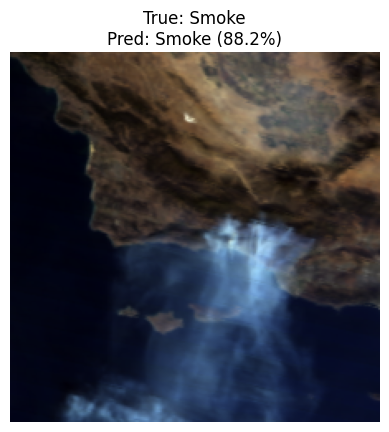

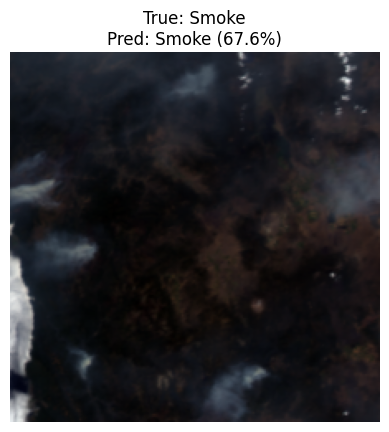

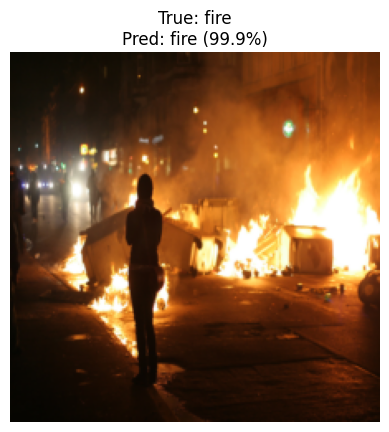

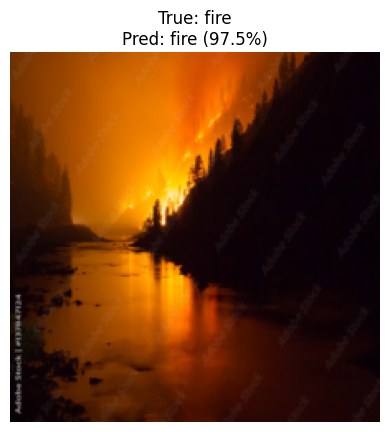

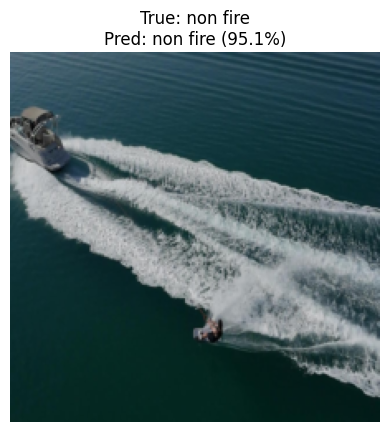

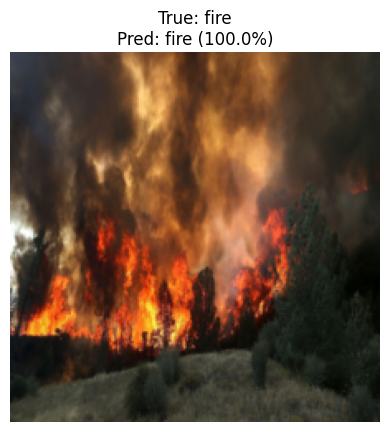

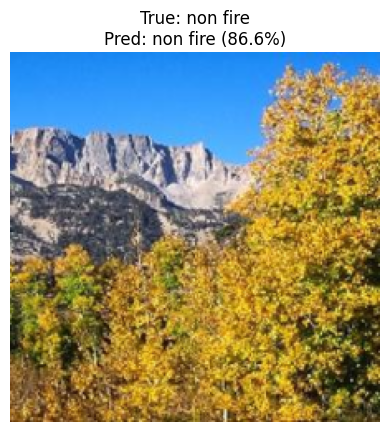

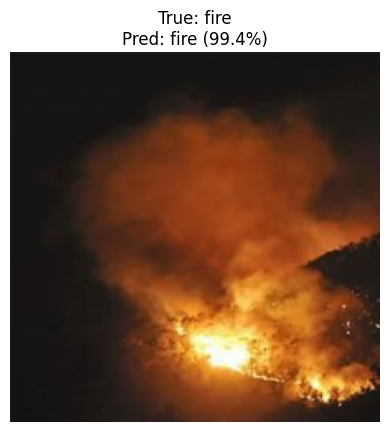

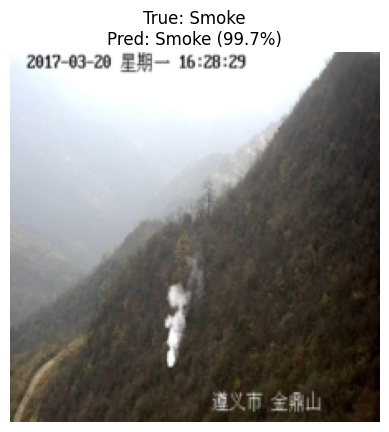

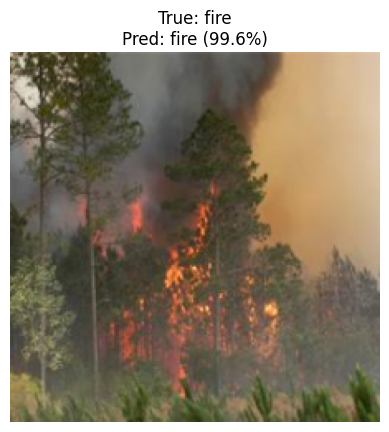

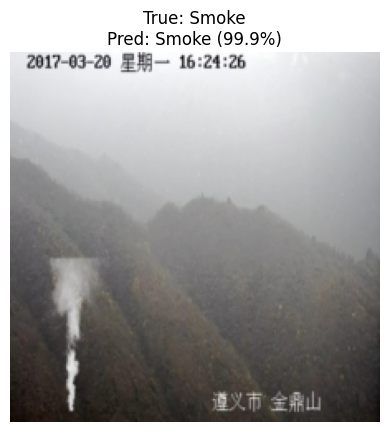

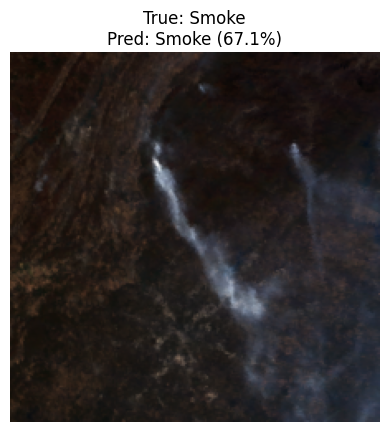

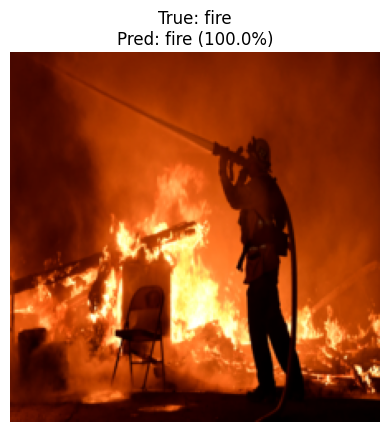

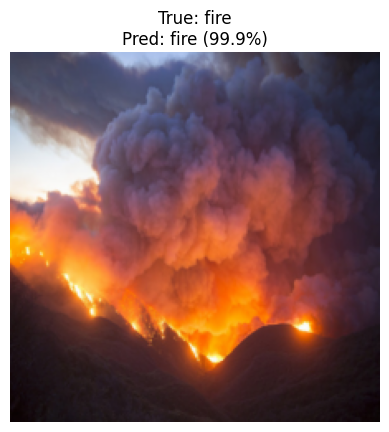

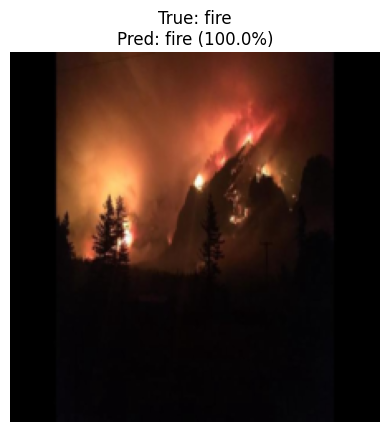

In [ ]:
import torch
import matplotlib.pyplot as plt
import torchvision
import numpy as np

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to display images
def imshow(img, title):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis("off")
    plt.show()

# Evaluate on the whole test subset
model.eval()
correct, total = 0, 0

all_images, all_labels, all_preds, all_probs = [], [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (preds == labels).sum().item()

        # Keep a batch for visualization
        if len(all_images) == 0:
            all_images = images
            all_labels = labels
            all_preds = preds
            all_probs = probs

accuracy = 100 * correct / total
print(f"Test Subset Accuracy: {accuracy:.2f}%")

# Show first 8 images from the batch with predictions
classes = train_dataset.classes
for i in range(15):
    img = all_images[i].cpu()
    true_label = classes[all_labels[i].item()]
    pred_label = classes[all_preds[i].item()]
    confidence = all_probs[i][all_preds[i]].item() * 100
    imshow(img, f"True: {true_label}\nPred: {pred_label} ({confidence:.1f}%)")


In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

def predict_custom_image(image_path, model, classes, device):
    """
    Predict a single image using the loaded model and show class probabilities.

    Args:
        image_path (str): Path to the image.
        model (torch.nn.Module): Loaded model.
        classes (list): List of class names.
        device (torch.device): Device (cuda or cpu).
    """

    # Load and transform the image
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    # Predict
    model.eval()
    with torch.no_grad():
        outputs = model(input_tensor)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        conf, pred_idx = torch.max(probs, 1)

    # Show image
    plt.imshow(np.array(image))
    plt.axis("off")
    plt.title(f"Predicted: {classes[pred_idx.item()]} ({conf.item()*100:.1f}%)")
    plt.show()

    #  Print all class probabilities
    print("Class probabilities:")
    for i, c in enumerate(classes):
        print(f"{c}: {probs[0][i].item()*100:.2f}%")

    return classes[pred_idx.item()], conf.item(), probs.cpu().numpy()


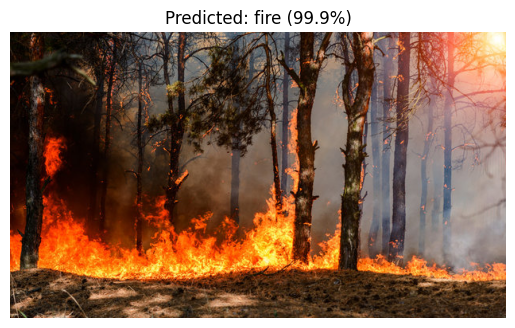

Class probabilities:
Smoke: 0.02%
fire: 99.91%
non fire: 0.06%


In [ ]:
image_path = "/content/drive/MyDrive/ml_ops_project_version1/fire_image_test.jpg"  # replace with your image path
pred_label, confidence, all_probs = predict_custom_image(image_path, model, train_dataset.classes, device)


In [7]:
pip install gradio
# !pip install --upgrade gradio



In [2]:
import gradio as gr
from PIL import Image
import torch
from torchvision import transforms
from torchvision import models
import torch.nn as nn
import numpy as np

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Model
model = models.resnet18(weights=None)  # No pretrained weights
model.fc = nn.Linear(model.fc.in_features, 3)  # 3 classes: ['Smoke', 'fire', 'non fire']
model.load_state_dict(torch.load("/content/drive/MyDrive/ml_ops_project_version1/fire_smoke_model.pth", map_location=device))
model = model.to(device)
model.eval()

# Classes
classes = ['Smoke', 'fire', 'non fire']

# Prediction Function
def predict(image):
    # Transform image
    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
    ])
    img = transform(image).unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        outputs = model(img)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        conf, pred_idx = torch.max(probs,1)

    # Prepare output
    label = classes[pred_idx.item()]
    confidence = conf.item()*100
    probs_dict = {classes[i]: float(probs[0][i]*100) for i in range(len(classes))}

    return f"{label} ({confidence:.2f}%)", probs_dict

# Gradio Interface
iface = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs=[gr.Textbox(label="Prediction"), gr.Label(num_top_classes=3, label="Class Probabilities")],
    title="Forest Fire & Smoke Detection",
    description="Upload an image of a forest scene and the model will predict whether it is Fire, Smoke, or Non Fire."
)

# Launch
iface.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://4fbe1f0c87c77ae9b0.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
